### Import Libraries:

In [1]:
## Imports
import os
import sys
import random
import numpy as np
import cv2
import math
from PIL import Image
import tensorflow as tf
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

## Seeding
seed = 42
random.seed = seed
np.random.seed = seed
tf.seed = seed

### Training
from tensorflow import keras
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from keras.callbacks import EarlyStopping
from keras import backend as K

In short: The training set is the data that is used to tell the neural network model that 'this is what a wound and coin looks like'. The validation data set is images of wounds and coins that the neural network will not see as part of the training, so you can test how well or how badly it does in evaluating if an image contains a wound and a coin.

Let's define each of these directories:

In [2]:
train_path, valid_path = 'data/train', 'data/validation'
training_images, training_labels = 'data/train/images/', 'data/train/labels/'
validation_images, validation_labels = 'data/validation/images/', 'data/validation/labels/'
test_images = 'data/test'

In [3]:
images_names = os.listdir(training_images)

Let's see the dimensions of the images:

In [4]:
im = cv2.imread(training_images+'/0011.png')

print('Training image dimensions = ',im.shape)

im = cv2.imread(training_labels+'/0011.png')

print('Label image dimensions = ',im.shape)

Training image dimensions =  (512, 512, 3)
Label image dimensions =  (512, 512, 3)


Now, let's see what the filenames look like in the `images` and `labels` `train` directories (file naming conventions are the same in the `validation` directory):

In [5]:
train_dir_fname = os.listdir(training_images)
train_dir_labels = os.listdir(training_labels)

print('Sample of Training Data images names:\n\n', train_dir_fname[:10], '\n')
print('Sample of Training Data labels names:\n\n', train_dir_labels[:10], '\n')

validation_dir_fname = os.listdir(validation_images)
validation_dir_labels = os.listdir(validation_labels)

print('Sample of Validation Data images names:\n\n', validation_dir_fname[:10], '\n')
print('Sample of Validation Data labels names:\n\n', validation_dir_labels[:10], '\n')

Sample of Training Data images names:

 ['0298.png', '0267.png', '0501.png', '0515.png', '0273.png', '0529.png', '0918.png', '0924.png', '0930.png', '0703.png'] 

Sample of Training Data labels names:

 ['0298.png', '0267.png', '0501.png', '0515.png', '0273.png', '0529.png', '0918.png', '0924.png', '0930.png', '0703.png'] 

Sample of Validation Data images names:

 ['0717.png', '0887.png', '0475.png', '0058.png', '0528.png', '0516.png', '0728.png', '0847.png', '0674.png', '0339.png'] 

Sample of Validation Data labels names:

 ['0717.png', '0887.png', '0475.png', '0058.png', '0528.png', '0516.png', '0728.png', '0847.png', '0674.png', '0339.png'] 



Let's find out the total number of cat and dog images in the `train`, `validation`, and `test` directories:

In [6]:
print('Training Images = ', len(train_dir_fname))
print('Training Labels = ', len(train_dir_labels))

print('Validation Images = ', len(validation_dir_fname))
print('Validation Labels = ', len(validation_dir_labels))

print('Test Images = ', len(os.listdir(os.path.join(test_images, 'images'))))

Training Images =  810
Training Labels =  810
Validation Images =  200
Validation Labels =  200
Test Images =  200


Now let's take a look at a few pictures to get a better sense of what the `wound` and `coin` datasets look like:

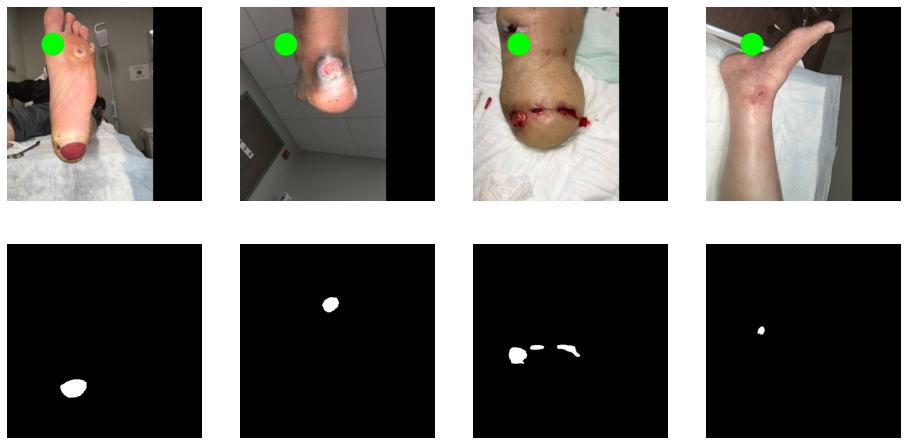

In [7]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 2
ncols = 4

pic_index = 0 # Index for iterating over images

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=4

next_pix = [os.path.join(training_images, fname) 
                for fname in train_dir_fname[ pic_index-4:pic_index] 
               ]

next_label_pix = [os.path.join(training_labels, fname) 
                for fname in train_dir_labels[ pic_index-4:pic_index]
               ]

for i, img_path in enumerate(next_pix+next_label_pix):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network.

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In [8]:
class DataGen(keras.utils.Sequence):
    
    def __init__(self, path, batch_size, image_size, labels=True, shuffle=True ,aug_ratio=0.5):
        self.image_size = image_size
        self.batch_size = batch_size
        #setting the ratio of augmented samples
        self.aug_ratio = aug_ratio
        self.path = path
        self.list_IDs = os.listdir(os.path.join(self.path, 'images'))
        self.labels = labels
        if labels:
            self.label_IDs = os.listdir(os.path.join(self.path, 'labels'))
        self.shuffle = shuffle
        self.on_epoch_end()
        # adding 2 arrays for images and labels augmeters in the class
        #check this link https://www.tensorflow.org/api_docs/python/tf/keras/layers/
        self.augment_inputs =[tf.keras.layers.RandomFlip(mode="horizontal", seed=seed),
                              tf.keras.layers.RandomFlip(mode="vertical", seed=seed),                              
                              tf.keras.layers.RandomRotation(factor=0.2,seed=seed),
                              tf.keras.layers.RandomZoom(height_factor=(-0.1,0.1),width_factor=(-0.1,0.1),seed=seed)] 
        self.augment_labels = [tf.keras.layers.RandomFlip(mode="horizontal", seed=seed),
                              tf.keras.layers.RandomFlip(mode="vertical", seed=seed),                             
                              tf.keras.layers.RandomRotation(factor=0.2,seed=seed),
                              tf.keras.layers.RandomZoom(height_factor=(-0.1,0.1),width_factor=(-0.1,0.1),seed=seed)]
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, 'images', id_name)

        ## Reading Image
        image = cv2.imread(image_path, 1)[:,:,::-1]
        image = cv2.resize(image, self.image_size)
        
        if self.labels:
            mask_path = os.path.join(self.path, 'labels', id_name)
            mask = cv2.imread(mask_path, 1)[:,:,::-1]
            mask = cv2.resize(mask[:,:,1], self.image_size)
            mask = np.expand_dims(mask, axis=-1)
            mask = mask/255.0
            
        ## Normalizaing 
        image = image/255.0
        
        if self.labels:
            return image, mask
        
        else:
            return image
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.list_IDs):
            self.batch_size = len(self.list_IDs) - index*self.batch_size
        
        files_batch = self.list_IDs[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            
            if self.labels:
                _img, _mask = self.__load__(id_name)
                mask.append(_mask)
                
            else:
                _img = self.__load__(id_name) 
            image.append(_img)
            
        image = np.array(image)
        mask  = np.array(mask)
        #selecting random index from augmenters array
        randomIdx = np.random.randint(len(self.augment_inputs))
        #calculating the number of augmented samples based on ratio and epoch size
        num_augmented = int(self.aug_ratio*len(image))
        #augment iamges
        image[:num_augmented] = self.augment_inputs[randomIdx](image[:num_augmented])
        if self.labels:
            #augment labels
            image[:num_augmented] = self.augment_labels[randomIdx](image[:num_augmented])
            return image, mask
        else:
            return image
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        return math.ceil(len(self.list_IDs) / self.batch_size)

Let's define some constants to make tuning easier:

In [9]:
parameters = {
    'image_size': (256, 256),
    'epochs': 2000,
    'num_channels': 3,
    'batch_size': 2,
    'optimizer': tf.keras.optimizers.Adam(lr=1e-4),
    'loss': 'binary_crossentropy'
}

/Users/mohamedgamal/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Let's run the generator on the `train` and `validation` datasets:

In [10]:
train_steps = len(train_dir_fname)//parameters['batch_size']
valid_steps = len(validation_dir_fname)//parameters['batch_size']

train_generator = DataGen(train_path, batch_size=parameters['batch_size'],
                          image_size=parameters['image_size'])

validation_generator = DataGen(valid_path, batch_size=parameters['batch_size'],
                               image_size=parameters['image_size'])

parameters['train_steps'] = train_steps
parameters['valid_steps'] = valid_steps
parameters['train_generator'] = train_generator
parameters['validation_generator'] = validation_generator

### Model Details:

<center><img src='images/unet.png' style="width:700px;height:400;"></center>
<caption><center> <u><b> Figure 2 </u></b>: U-Net Architecture<br> </center></caption>

**Contracting path** (Encoder containing downsampling steps):

Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 unpadded convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

**Crop function**: This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection. 

**Expanding path** (Decoder containing upsampling steps):

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. You need to perform cropping to handle the loss of border pixels in every convolution.

**Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when you use 1x1 convolutions, you can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, you can reduce the channel dimensions to have one layer per class. 

The U-Net network has 23 convolutional layers in total.

### Encoder (Downsampling Block): 

<center><img src="images/encoder.png" style="width:500px;height:500;"></center>
<caption><center> <u><b>Figure 3</u></b>: The U-Net Encoder up close <br> </center></caption>

The encoder is a stack of various conv_blocks:

Each `conv_block()` is composed of 2 **Conv2D** layers  with ReLU activations. We will apply **Dropout**, and **MaxPooling2D** to some conv_blocks, as you will verify in the following sections, specifically to the last two blocks of the downsampling. 

The function will  return two tensors: 
- `next_layer`: That will go into the next block. 
- `skip_connection`: That will go into the corresponding decoding block.

**Note**: If `max_pooling=True`, the `next_layer` will be the output of the MaxPooling2D layer, but the `skip_connection` will be the output of the previously applied layer(Conv2D or Dropout, depending on the case). Else, both results will be identical.  

In [11]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D((2,2))(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

### Decoder (Upsampling Block):

The decoder, or upsampling block, upsamples the features back to the original image size. At each upsampling level, you'll take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block.

<center><img src="images/decoder.png" style="width:500px;height:500;"></center>
<caption><center> <u><b>Figure 4</u></b>: The U-Net Decoder up close <br> </center></caption>

There are two new components in the decoder: `up` and `merge`. These are the transpose convolution and the skip connections. In addition, there are two more convolutional layers set to the same parameters as in the encoder. 

Here you'll encounter the `Conv2DTranspose` layer, which performs the inverse of the `Conv2D` layer.


In [12]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 (3,3),     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 (3,3),   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    
    return conv

### Build the Model:

This is where you'll put it all together, by chaining the encoder, bottleneck, and decoder! You'll need to specify the number of output channels, which for this particular set would be 23. That's because there are 23 possible labels for each pixel in this self-driving car dataset. 

For the function `unet_model`, specify the input shape, number of filters, and number of classes (23 in this case).

For the first half of the model:

* Begin with a conv block that takes the inputs of the model and the number of filters
* Then, chain the first output element of each block to the input of the next convolutional block
* Next, double the number of filters at each step
* Beginning with `conv_block4`, add `dropout_prob` of 0.3
* For the final conv_block, set `dropout_prob` to 0.3 again, and turn off max pooling  

For the second half:

* Use cblock5 as expansive_input and cblock4 as contractive_input, with `n_filters` * 8. This is your bottleneck layer. 
* Chain the output of the previous block as expansive_input and the corresponding contractive block output.
* Note that you must use the second element of the contractive block before the max pooling layer. 
* At each step, use half the number of filters of the previous block
* `conv9` is a Conv2D layer with ReLU activation, He normal initializer, `same` padding
* Finally, `conv10` is a Conv2D that takes the number of classes as the filter, a kernel size of 1, and "same" padding. The output of `conv10` is the output of your model. 

In [13]:
def unet_model(input_size=(256, 256, 3), n_filters=64, n_classes=1):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters * 2)
    cblock3 = conv_block(cblock2[0], n_filters * 4)
    cblock4 = conv_block(cblock3[0], n_filters * 8, dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    cblock5 = conv_block(cblock4[0], n_filters * 16, dropout_prob=0.3, max_pooling=False) 
    
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters * 1)
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # A Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(n_classes, kernel_size=1, padding='same', activation='sigmoid')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [14]:
img_height = 256
img_width = 256
num_channels = 3

unet = unet_model((img_height, img_width, num_channels), n_classes=1)

2022-01-02 16:03:21.218818: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Let's check model Summary:

In [15]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

### Defining a new loss/metric functions for the UNET:

In [16]:
callbacks = EarlyStopping(monitor='val_dice_coef', patience=200, mode='max', restore_best_weights=True)

In [17]:
def dice_coef(y_true, y_pred):
    smooth = 0.00001
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / ((K.sum(y_true_f) + K.sum(y_pred_f)) + smooth)
    return score


# Recall (true positive rate)
def recall(truth, prediction):
    TP = K.sum(K.round(K.clip(truth * prediction, 0, 1)))
    P = K.sum(K.round(K.clip(truth, 0, 1)))
    return TP / (P + K.epsilon())


# Precision (positive prediction value)
def precision(truth, prediction):
    TP = K.sum(K.round(K.clip(truth * prediction, 0, 1)))
    FP = K.sum(K.round(K.clip((1-truth) * prediction, 0, 1)))
    return TP / (TP + FP + K.epsilon())

In [18]:
parameters['metric'] = [dice_coef, precision, recall]

# Train Model:

In [19]:
unet.compile(optimizer=parameters['optimizer'],
              loss=parameters['loss'],
              metrics=parameters['metric'])

In [20]:
unet = tf.keras.models.load_model('my_model.h5', custom_objects={'recall':recall,
                                 'precision':precision,
                                 'dice_coef': dice_coef})

history = unet.fit(parameters['train_generator'],
                              validation_data=parameters['validation_generator'],
                              steps_per_epoch=parameters['train_steps'],
                              validation_steps=parameters['valid_steps'],
                              epochs=parameters['epochs'], callbacks=[callbacks])

### Save checkpoints:

unet.save_weights('./checkpoints/my_checkpoint')

### Save final model:

unet.save('my_model.h5')

!mkdir -p saved_model
unet.save('saved_model/my_model')

## Predict `test` images:

In [21]:
test_generator = DataGen(test_images, batch_size=parameters['batch_size'],
                          image_size=parameters['image_size'], labels=False)

In [22]:
output = unet.predict(test_generator)

### Check out the some of the unmasked and masked images from the dataset:

In [23]:
image_list = os.listdir(training_images)
mask_list = os.listdir(training_labels)

image_list = [training_images+i for i in image_list]
mask_list = [training_labels+i for i in mask_list]

image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

In [24]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, parameters['image_size'], method='nearest')
    input_mask = tf.image.resize(mask, parameters['image_size'], method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [25]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        img = np.array(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.imshow(img)
        plt.axis('off')
    plt.show()

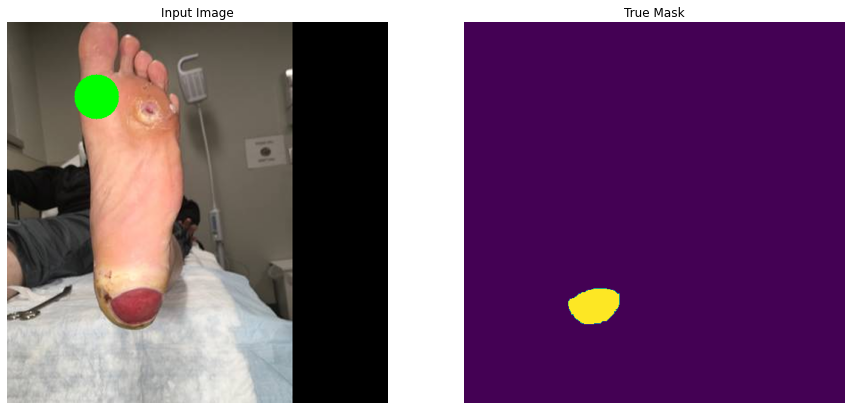

In [26]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask

display([sample_image, sample_mask])

### Show Predictions 

Next, check your predicted masks against the true mask and the original input image:

In [27]:
def create_mask(pred_mask, idx=0):
    pred_mask[pred_mask >= 0.25] = 1
    pred_mask[pred_mask < 0.25] = 0
    size = np.sum(pred_mask[idx])
    return pred_mask[idx], size

In [28]:
def calculate_coin(image):
    color_to_seek = (0, 1, 0)
    amount = 0
    image = np.array(image)
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            b, g, r = image[x, y]
            if (b, g, r) == color_to_seek:
                amount += 1
    return amount

In [29]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            wound_mask, wound_size = create_mask(pred_mask)
            coin_size = calculate_coin(image[0])
            print('Wound size = ', wound_size, 'px\t, Coin size = ', coin_size, 'px\t, Ratio = ', '{:.2f}'.format(wound_size/coin_size))
            display([image[0], mask[0], wound_mask])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

Wound size =  659.0 px	, Coin size =  716 px	, Ratio =  0.92


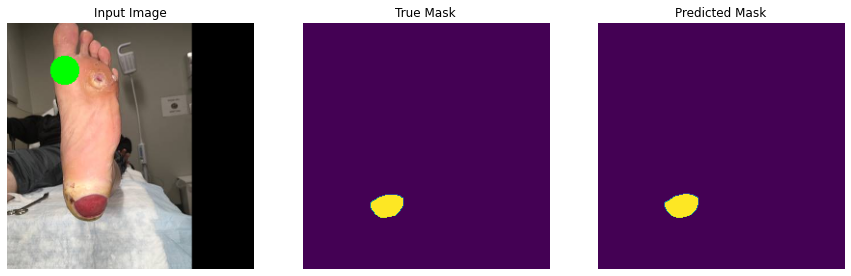

Wound size =  757.0 px	, Coin size =  716 px	, Ratio =  1.06


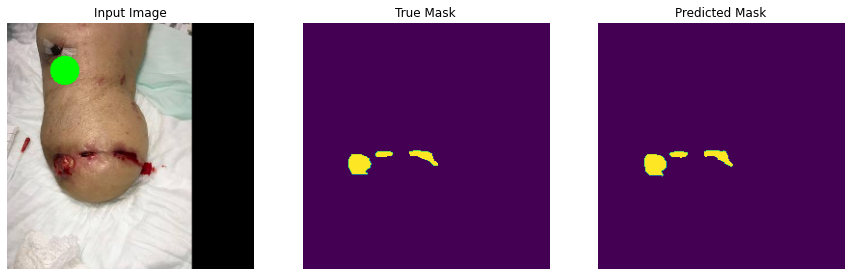

Wound size =  307.0 px	, Coin size =  716 px	, Ratio =  0.43


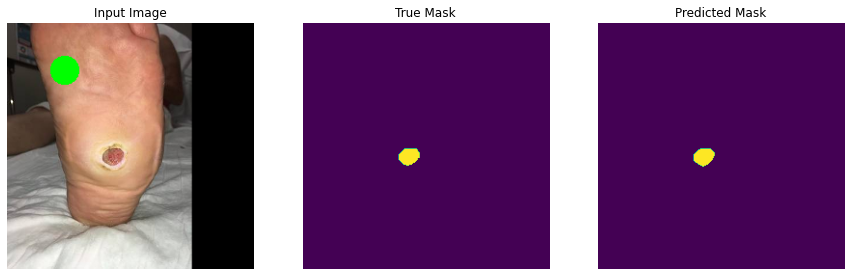

Wound size =  84.0 px	, Coin size =  716 px	, Ratio =  0.12


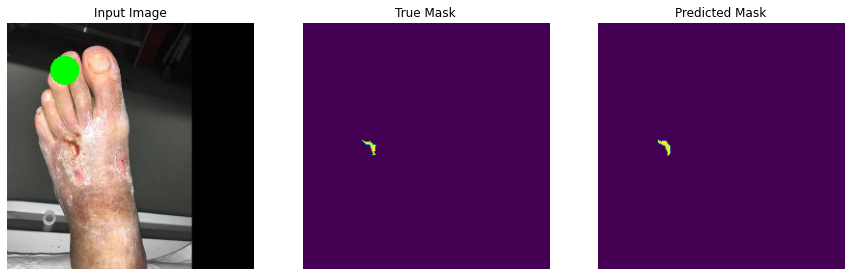

Wound size =  553.0 px	, Coin size =  716 px	, Ratio =  0.77


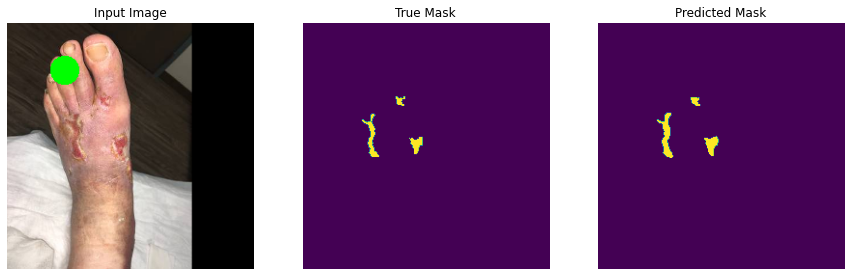

Wound size =  112.0 px	, Coin size =  716 px	, Ratio =  0.16


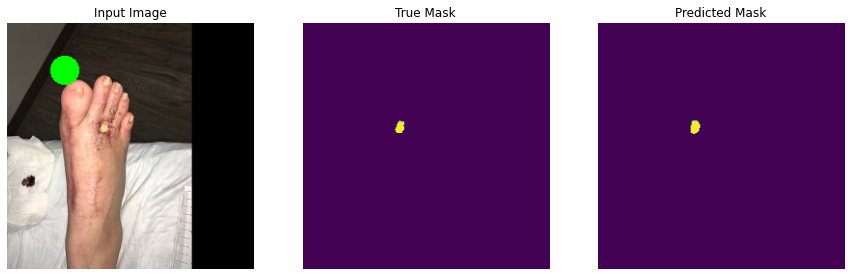

2022-01-02 16:04:41.414293: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [30]:
train_dataset = processed_image_ds.batch(parameters['batch_size']).cache()

show_predictions(train_dataset, 6)